<a href="https://colab.research.google.com/github/kdidi99/aml/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ConvNets with PyTorch (Exercise sheet 3)

Kieran Didi, Mohammadhossein Jafari , Szymon Szmajdzinski 



In [ ]:
!nvidia-smi

Thu Jun  9 06:39:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    33W /  70W |   1248MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1 Introduction

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Epoch: 0
Mean Train Loss: 3.88e-01
Mean Test Loss:  2.19e-01
Epoch: 10
Mean Train Loss: 1.49e-01
Mean Test Loss:  3.35e-01
Epoch: 20
Mean Train Loss: 9.82e-02
Mean Test Loss:  3.55e-01
Epoch: 30
Mean Train Loss: 7.54e-02
Mean Test Loss:  5.76e-01
Epoch: 40
Mean Train Loss: 5.76e-02
Mean Test Loss:  6.35e-01
Epoch: 50
Mean Train Loss: 4.57e-02
Mean Test Loss:  6.91e-01
Epoch: 60
Mean Train Loss: 3.18e-02
Mean Test Loss:  8.78e-01
Epoch: 70
Mean Train Loss: 2.55e-02
Mean Test Loss:  8.59e-01
Epoch: 80
Mean Train Loss: 1.96e-02
Mean Test Loss:  8.48e-01
Epoch: 90
Mean Train Loss: 1.76e-02
Mean Test Loss:  8.81e-01
Epoch: 100
Mean Train Loss: 1.03e-02
Mean Test Loss:  7.67e-01


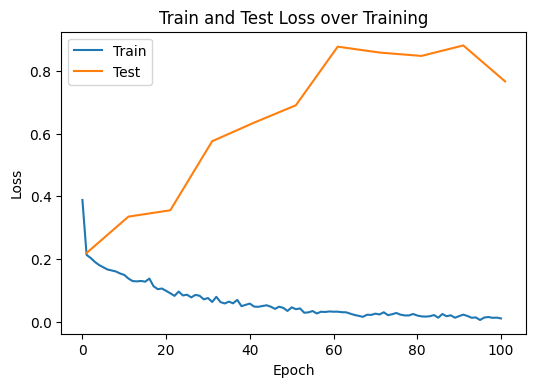

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


# 2 Dropout

In [ ]:
def dropout(X, p_drop=0.5):
  #check that p_drop is in correct range
  assert 0 <= p_drop < 1
  if p_drop == 0:
    return X
  else:
    rng = np.random.default_rng()
    phi = rng.binomial(1, p_drop, X.shape)
    phi = phi.astype(np.float32)
    phi[phi==1] = 0
    phi[phi==0] = 1/(1-p_drop)
    X = X * torch.from_numpy(phi)
    return X



In [21]:
def dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    x_drop = dropout(x, p_drop_input)
    h = rectify(x_drop @ w_h)
    h_drop = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    h2_drop = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax



In [ ]:
#training and testing new dropout model
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100
p_drop_input = 0.5
p_drop_hidden = 0.5

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = dropout_model(x, w_h, w_h2, w_o, 0, 0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


Epoch: 0
Mean Train Loss: 3.94e-01
Mean Test Loss:  3.18e-01
Epoch: 10
Mean Train Loss: 1.45e-01
Mean Test Loss:  2.48e-01
Epoch: 20
Mean Train Loss: 9.26e-02
Mean Test Loss:  4.87e-01


Dropout "disables" a subset of neurons in the network with a certain probability (here taken 0.25 and 0.5) during the training process; the subset changes during each training epoch.

The neurons that are still active cannot rely on their disabled neighbours and learn to be robust w.r.t. missing inputs; subtle co-adaptations of several neurons cannot occur which reduces overfitting.

The network without dropout overfits a lot (test error increases basically from the start whereas training error goes down); the dropout model 

# 3 Parametric ReLU

In [ ]:
def PRelu(X,a):
  neg_val = torch.min(torch.zeros_like(x), x)
  add = neg_val * a
  return rectify(X)+add

def init_a(dims):
  a = torch.zeros(size=dims)
  #allow PyTorch to optimize a
  a.requires_grad = True
  return a

In [ ]:
def prelu_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden, a_1, a_2):
    x_drop = dropout(x, p_drop_input)
    h = PRelu(x_drop @ w_h, a_1)
    h_drop = dropout(h, p_drop_hidden)
    h2 = PRelu(h @ w_h2, a_2)
    h2_drop = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [ ]:
#training and testing new PReLU model
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)
a_1 = init_a((batch_size, 625))
a_2 = init_a((batch_size, 625))

optimizer = RMSprop(params=[w_h, w_h2, w_o, a_1, a_2])

n_epochs = 100
p_drop_input = 0.5
p_drop_hidden = 0.5

train_loss = []
test_loss = []


# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = dropout_model(x, w_h, w_h2, w_o, 0, 0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


# 4.1 Create a convolutional network

In [ ]:
from torch.nn.functional import conv2d, max_pool2d

In [ ]:
trainX = trainX.reshape(-1, 1, 28, 28) #training data
testX = testX.reshape(-1, 1, 28,28)

In [ ]:
def convnet_model(X, w_conv1, w_conv2, w_conv3, w_h2, w_o, p_drop_input, p_drop_hidden, a_1, a_2):
    x_drop = dropout(x, p_drop_input)

    conv1 = rectify(conv2d(x_drop, w_conv1))
    maxpool1 = max_pool2d(conv1, (2,2))
    drop1 = dropout(maxpool1, p_drop_hidden)

    conv2 = rectify(conv2d(drop1, w_conv2))
    maxpool2 = max_pool2d(conv2, (2,2))
    drop2 = dropout(maxpool2, p_drop_hidden)

    conv3 = rectify(conv2d(drop2, w_conv3))
    maxpool3 = max_pool2d(conv3, (2,2))
    drop3 = dropout(maxpool3, p_drop_hidden)

    h2 = rectify(torch.reshape(drop3, (batch_size, 128)) @ w_h2)
    h2_drop = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

# 4.2 Application of Convolutional network